### Regressogram test

I'll implement CLMM solution first and then change it to compare to other statistics

In [1]:
# For NumCosmo
import os
import sys
import gi

gi.require_version('NumCosmo', '1.0')
gi.require_version('NumCosmoMath', '1.0')
from gi.repository import GObject
from gi.repository import NumCosmo as Nc
from gi.repository import NumCosmoMath as Ncm

from scipy.stats import chi2

import math
# The corner package is needed to view the results of the MCMC analysis
import corner


os.environ['CLMM_MODELING_BACKEND'] = 'nc'

__name__ = "NcContext"

Ncm.cfg_init ()
Ncm.cfg_set_log_handler (lambda msg: sys.stdout.write (msg) and sys.stdout.flush ())

try: import clmm
except:
    import notebook_install
    notebook_install.install_clmm_pipeline(upgrade=False)
    import clmm
import matplotlib.pyplot as plt
import numpy as np
from numpy import random
from clmm.support.sampler import fitters

import clmm.dataops as da
import clmm.galaxycluster as gc
import clmm.theory as theory
from clmm import Cosmology
from clmm.support import mock_data as mock
from scipy.stats import binned_statistic
import matplotlib.pyplot as plt

np.random.seed(1)

In [2]:
mock_cosmo = Cosmology(H0 = 70.0, Omega_dm0 = 0.27 - 0.045, Omega_b0 = 0.045, Omega_k0 = 0.0)

cosmo = mock_cosmo
cluster_m = 1.e15 # M200,m [Msun]
cluster_z = 0.3   # Cluster's redshift
concentration = 4
ngals = 100000     # Number of galaxies
Delta = 200
cluster_ra = 0.0
cluster_dec = 0.0

ideal_data = mock.generate_galaxy_catalog(cluster_m, cluster_z, concentration, cosmo, 0.8, ngals=ngals)

cluster_id = "CL_ideal"
cl1 = clmm.GalaxyCluster(cluster_id, cluster_ra, cluster_dec,
                               cluster_z, ideal_data)

theta1, g_t1, g_x1 = cl1.compute_tangential_and_cross_components(geometry="flat")

# bin_edges = da.make_bins(5.2e-5, 6e-3, 15, method='evenlog10width')
bin_edges = da.make_bins(0.7, 4, 15, method='evenlog10width')


profile1 = cl1.make_radial_profile("Mpc", bins=bin_edges, cosmo=cosmo)

/home/caiooliveira/.local/lib/python3.10/site-packages/clmm-1.1.10-py3.10.egg/clmm/utils.py:176: RuntimeWarning: invalid value encountered in sqrt


In [3]:
for n in cl1.profile.colnames: cl1.profile[n].format = "%6.3e"
cl1.profile.pprint(max_width=-1)

radius_min   radius  radius_max     gt      gt_err      gx       gx_err      z       z_err     n_src  
---------- --------- ---------- --------- --------- ---------- --------- --------- --------- ---------
 7.000e-01 7.441e-01  7.863e-01 4.361e-02 4.141e-05 -3.619e-10 2.035e-10 8.000e-01       nan 6.110e+02
 7.863e-01 8.365e-01  8.831e-01 4.003e-02 3.648e-05  1.122e-11 2.159e-10 8.000e-01 5.094e-09 7.530e+02
 8.831e-01 9.405e-01  9.920e-01 3.655e-02 2.890e-05 -7.372e-11 2.128e-10 8.000e-01 3.440e-09 1.032e+03
 9.920e-01 1.054e+00  1.114e+00 3.331e-02 2.612e-05  4.234e-12 2.168e-10 8.000e-01 4.241e-09 1.278e+03
 1.114e+00 1.185e+00  1.251e+00 3.011e-02 2.295e-05  5.000e-11 2.215e-10 8.000e-01       nan 1.558e+03
 1.251e+00 1.330e+00  1.406e+00 2.712e-02 1.954e-05 -3.859e-10 2.279e-10 8.000e-01 2.210e-09 1.909e+03
 1.406e+00 1.494e+00  1.579e+00 2.429e-02 1.606e-05  3.167e-10 2.254e-10 8.000e-01       nan 2.489e+03
 1.579e+00 1.677e+00  1.773e+00 2.166e-02 1.301e-05 -1.198e-10 2.282e-10 

In [4]:
bin_edges = da.make_bins(2e-5, 6.1e-3, 15, method='evenlog10width')
gal_bins = binned_statistic(theta1, [theta1, g_t1], statistic='count', bins=bin_edges)[2]

gal_bins

array([12, 13, 15, ..., 13, 14, 15])

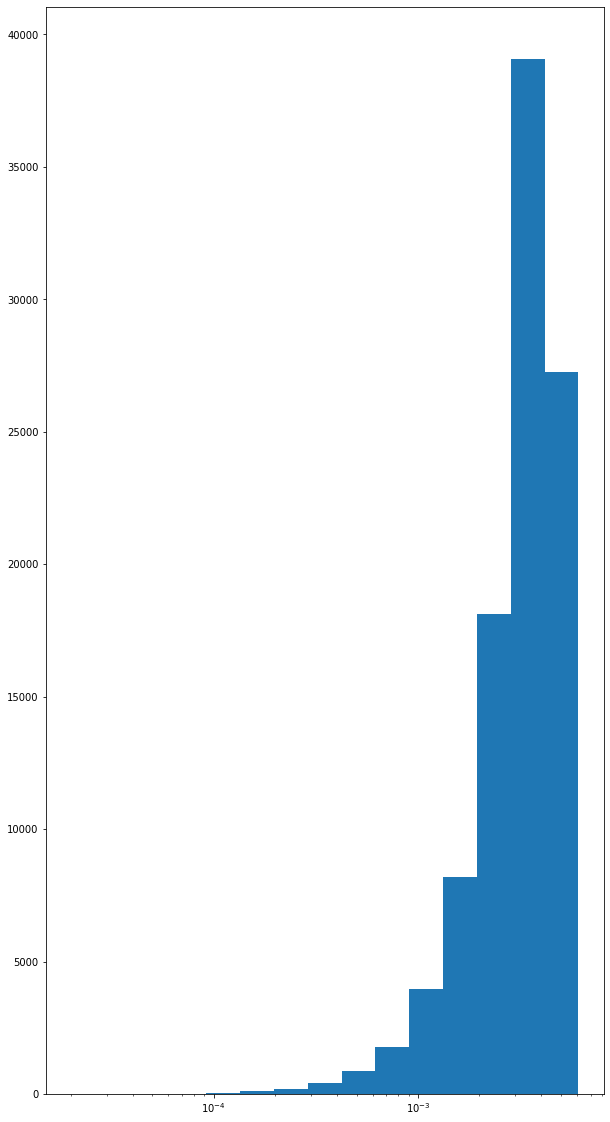

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(10,20), facecolor='white')

ax.hist(theta1, bins=bin_edges)
ax.set_xscale('log')

In [6]:
bins_gal = []
for i in range(15):
    bin_i = []
    for j in range(len(gal_bins)):
        if gal_bins[j] == i+1:
            bin_i.append(j)
    bins_gal.append(bin_i)
gal_bins
# list: each entry is a list with the galaxies belonging to the respective bin

array([12, 13, 15, ..., 13, 14, 15])

In [7]:
bins_gal_theta = []
for i in range(15):
    bin_i = []
    for gal_id in bins_gal[i]:
        bin_i.append(theta1[gal_id])
    bins_gal_theta.append(bin_i)
# bins_gal_theta

# same as bins_gal, but with theta instead of the galaxy number

In [8]:
bins_gal_gt = []
for i in range(15):
    bin_i = []
    for gal_id in bins_gal[i]:
        bin_i.append(g_t1[gal_id])
    bins_gal_gt.append(bin_i)
# bins_gal_theta

# same as bins_gal, but with gt instead of the galaxy number

In [9]:
bins_gal_gx = []
for i in range(15):
    bin_i = []
    for gal_id in bins_gal[i]:
        bin_i.append(g_x1[gal_id])
    bins_gal_gx.append(bin_i)
# bins_gal_theta

# same as bins_gal, but with gx instead of the galaxy number

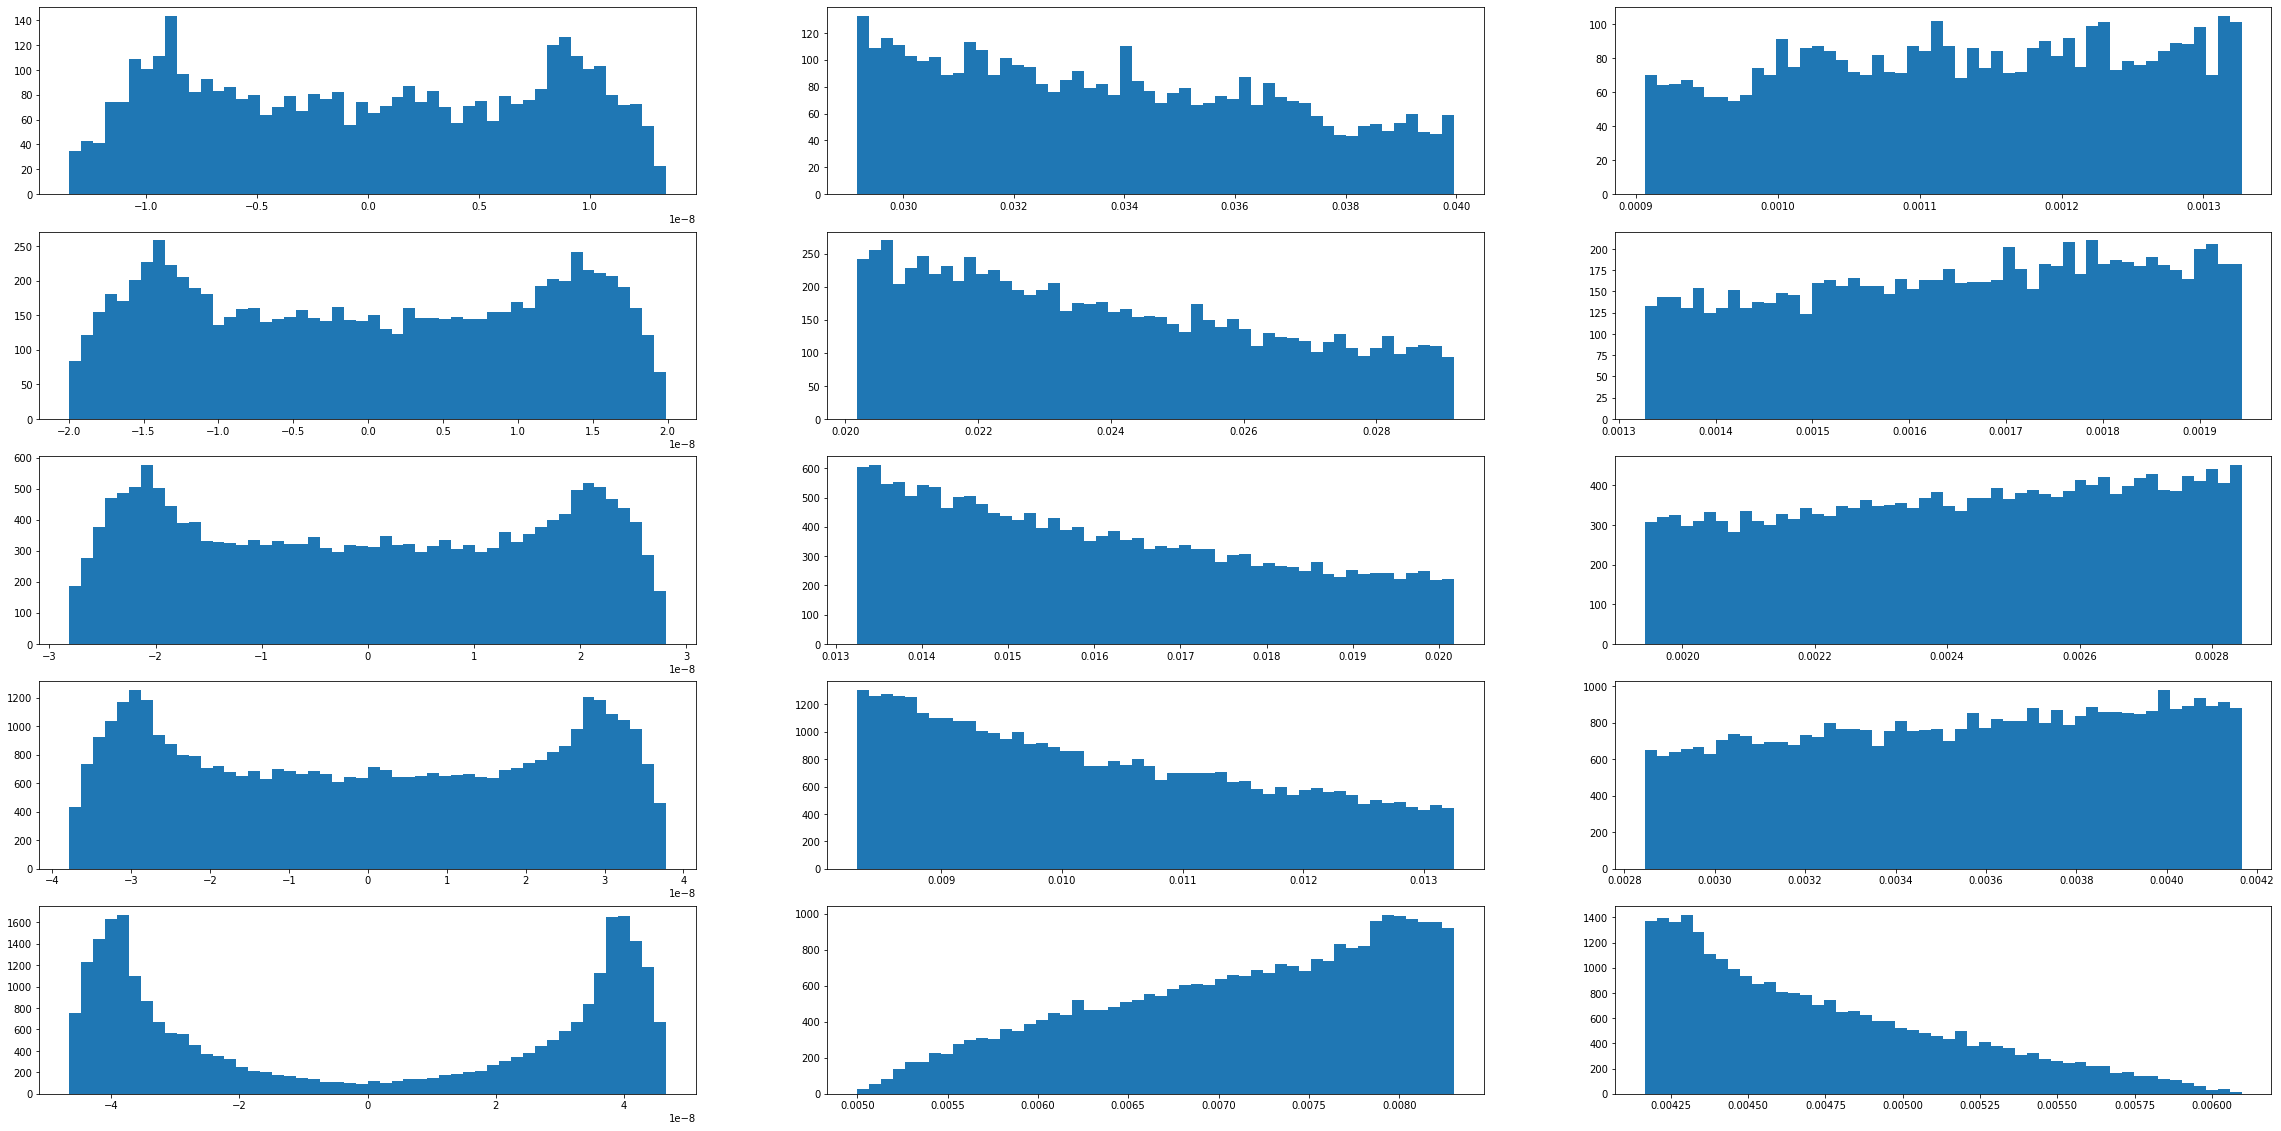

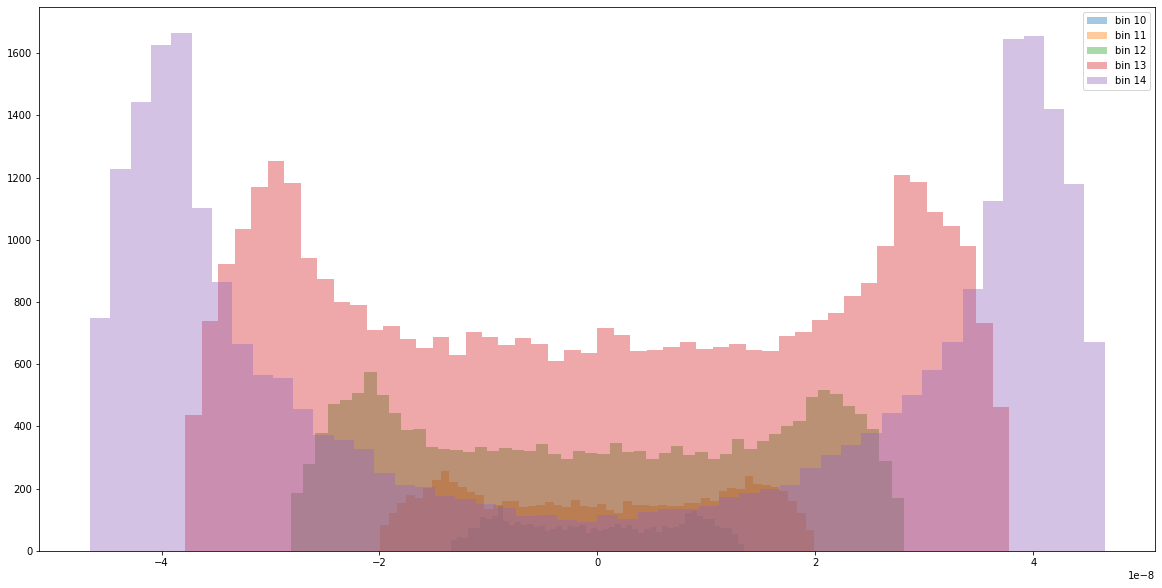

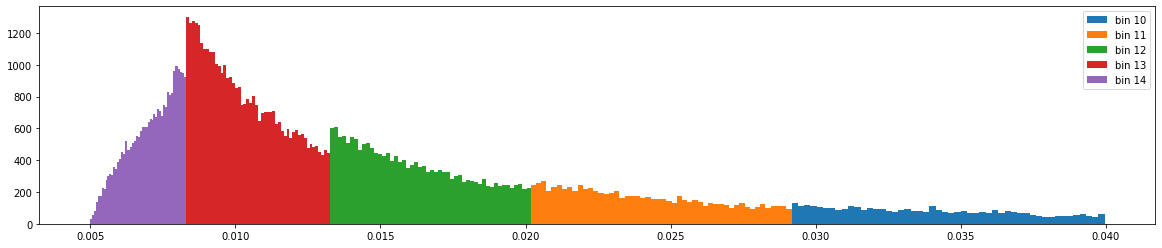

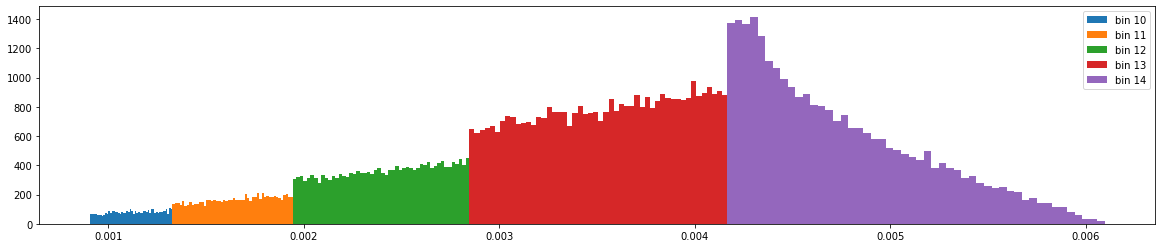

In [10]:
fig, ax = plt.subplots(5, 3, figsize=(40,20), facecolor="white")


for i in range(10,15):
    ax[i-10][0].hist(bins_gal_gx[i], bins=50)
    ax[i-10][1].hist(bins_gal_gt[i], bins=50)
    ax[i-10][2].hist(bins_gal_theta[i], bins=50)

# #plotting the histogram for gx, gt and theta in the 4 last bins (the most populated ones)

fig, ax = plt.subplots(1, 1, figsize=(20,10), facecolor="white")


for i in range(10, 15):
    ax.hist(bins_gal_gx[i], bins=50, label=f"bin {i}", alpha=0.4)
ax.legend()


for data in [bins_gal_gt, bins_gal_theta]:
    fig, ax = plt.subplots(1, 1, figsize=(20,4), facecolor="white")


    for i in range(10, 15):
        ax.hist(data[i], bins=50, label=f"bin {i}")
    ax.legend()

### Creating EPDF from data

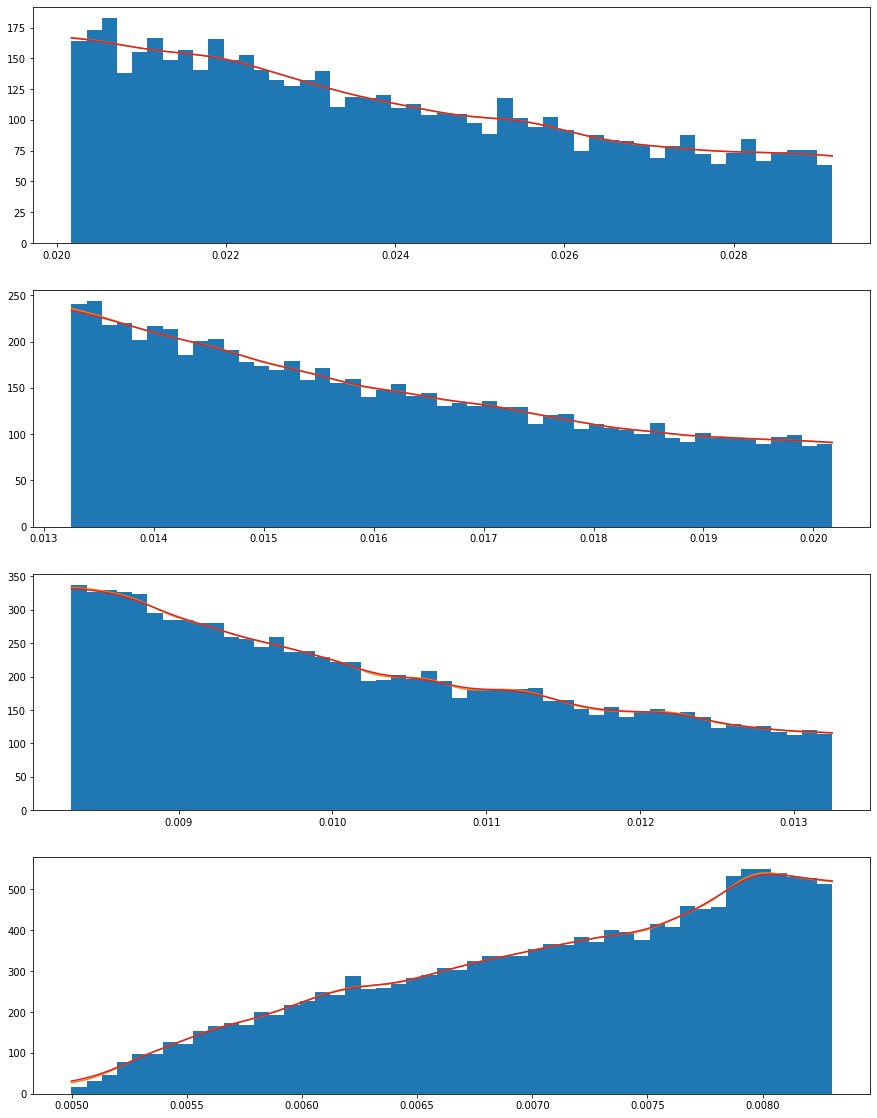

In [11]:
fig, ax = plt.subplots(4, 1, figsize=(15,20), facecolor="white")

for i in range(11,15):
    epdf_gt = Ncm.StatsDist1dEPDF.new_full (2000, Ncm.StatsDist1dEPDFBw.AUTO, 0.01, 0.001)
    epdf_rot_gt = Ncm.StatsDist1dEPDF.new_full (2000, Ncm.StatsDist1dEPDFBw.ROT, 0.01,  0.001)

    for gt in bins_gal_gt[i]:
        epdf_gt.add_obs(gt)
        epdf_rot_gt.add_obs(gt)

    epdf_gt.prepare()
    epdf_rot_gt.prepare()

    gt_min = min(bins_gal_gt[i])
    gt_max = max(bins_gal_gt[i])

    x = np.linspace(gt_min, gt_max, num=1000)
    y = [epdf_gt.eval_p(x_i) for x_i in x]
    z = [epdf_rot_gt.eval_p(x_i) for x_i in x]

    ax[i-11].hist(bins_gal_gt[i], bins=50, density=True)
    ax[i-11].plot(x, y, color='tab:orange')
    ax[i-11].plot(x, z, color='tab:red')

# DIES IF THERE'S TOO FEW GALAXIES

# plt.savefig("epdf_x_histogram.png")

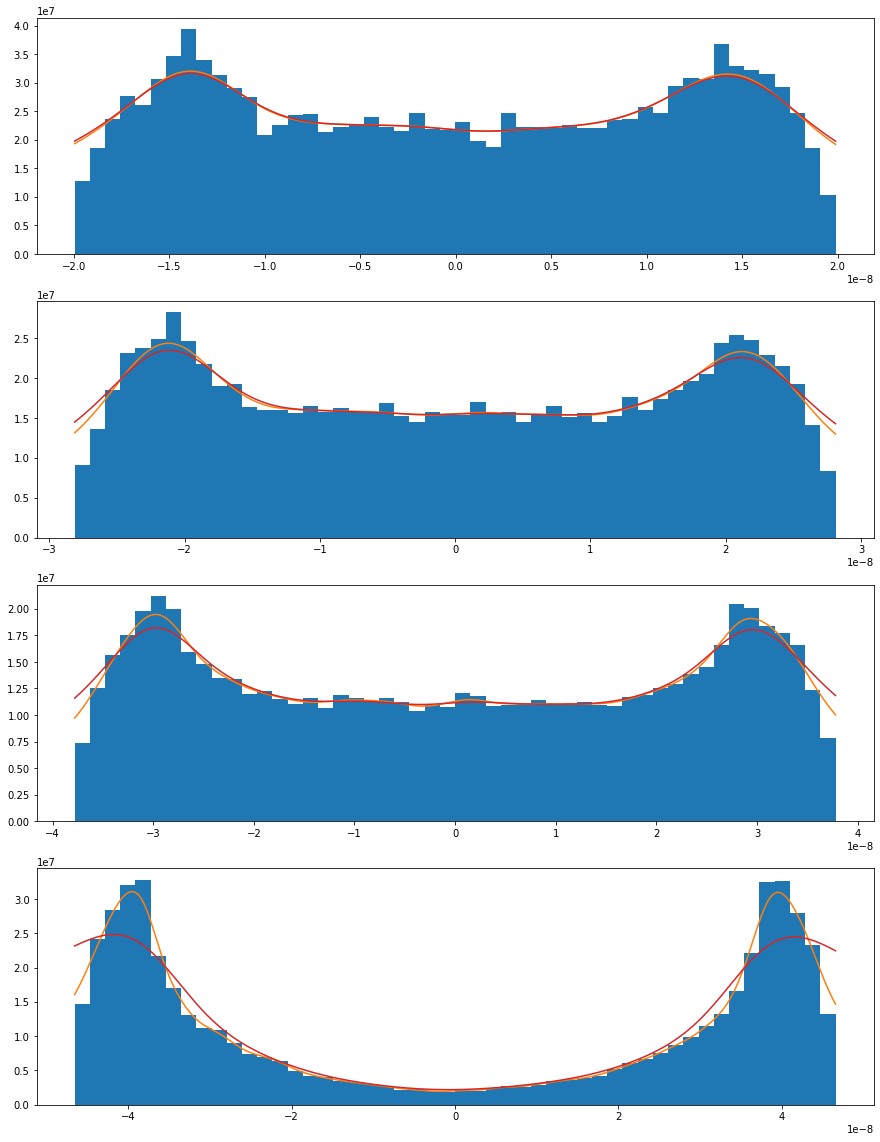

In [14]:
fig, ax = plt.subplots(4, 1, figsize=(15,20), facecolor="white")

for i in range(11,15):
    epdf_gx = Ncm.StatsDist1dEPDF.new_full (2000, Ncm.StatsDist1dEPDFBw.AUTO, 0.1, 0.001)
    epdf_rot_gx = Ncm.StatsDist1dEPDF.new_full (2000, Ncm.StatsDist1dEPDFBw.ROT, 0.1,  0.001)

    for gx in bins_gal_gx[i]:
        epdf_gx.add_obs(gx)
        epdf_rot_gx.add_obs(gx)

    epdf_gx.prepare()
    epdf_rot_gx.prepare()

    gx_min = min(bins_gal_gx[i])
    gx_max = max(bins_gal_gx[i])

    a = np.linspace(gx_min, gx_max, num=1000)
    b = [epdf_gx.eval_p(a_i) for a_i in a]
    c = [epdf_rot_gx.eval_p(a_i) for a_i in a]

    ax[i-11].hist(bins_gal_gx[i], bins=50, density=True)
    ax[i-11].plot(a, b, color='tab:orange')
    ax[i-11].plot(a, c, color='tab:red')
    

# plt.savefig("epdf_gx_histogram_working_maybe.png")

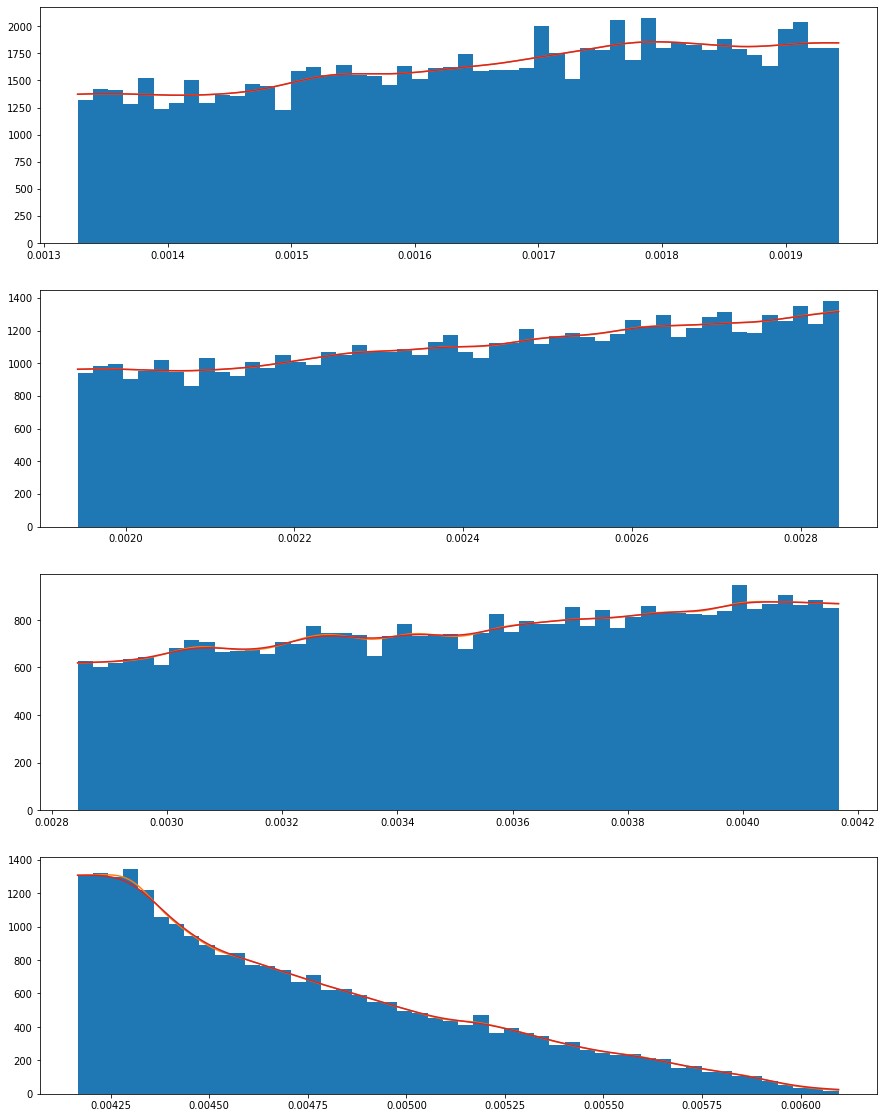

In [18]:
fig, ax = plt.subplots(4, 1, figsize=(15,20), facecolor="white")

scale = 1
# DIFFERENT SCALES LEAD TO REALLY DIFFERENT RESULTS

for i in range(11,15):
    epdf_theta = Ncm.StatsDist1dEPDF.new_full (2000, Ncm.StatsDist1dEPDFBw.AUTO, 1, 0.001)
    epdf_rot_theta = Ncm.StatsDist1dEPDF.new_full (2000, Ncm.StatsDist1dEPDFBw.ROT, 1,  0.001)

    for th in bins_gal_theta[i]:
        epdf_theta.add_obs(th*scale)
        epdf_rot_theta.add_obs(th*scale)

    epdf_theta.prepare()
    epdf_rot_theta.prepare()

    theta_min = min(bins_gal_theta[i])
    theta_max = max(bins_gal_theta[i])

    x = np.linspace(theta_min, theta_max, num=1000)
    y = [epdf_theta.eval_p(x_i*scale)*scale for x_i in x]
    z = [epdf_rot_theta.eval_p(x_i*scale)*scale for x_i in x]

    ax[i-11].hist(bins_gal_theta[i], bins=50, density=True)
    # ax2 = ax[i-11].twiny()
    # ax2.set_ylim(0, max(max(y), max(z))+scale*1e-9)
    ax[i-11].plot(x, y, color='tab:orange')
    ax[i-11].plot(x, z, color='tab:red')
    

